In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb

from sandpyper.outils import getLoc, getDate,coords_to_points
from sandpyper.dynamics import  BCDs_compute, steady_state_transect, compute_rBCD_transects, infer_weights

crs_dict_string={"mar":{'init': 'epsg:32754'},
         "leo":{'init': 'epsg:32755'}}

C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\explore\segregation\network\network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
C:\conda3\envs\sandpyper_env\lib\site-packages\pysal\model\spvcm\abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


## BCDs

In [2]:
# We use the hotspot sand-only beachface points that have been previously classified into dh magnitude classes (states)

in_file=r"C:\my_packages\doc_data\profiles\markov_tagged_df.csv"
dataset=pd.read_csv(in_file)

In [3]:
dataset["coordinates"]=dataset.geometry.apply(coords_to_points)
dataset_gdf=gpd.GeoDataFrame(dataset, geometry="coordinates",crs=crs_dict_string['mar'])
dataset_gdf.sort_values(['date_pre'], inplace=True)

C:\conda3\envs\sandpyper_env\lib\site-packages\pyproj\crs\crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [ ]:
dh_file["coordinates"]=dh_file.geometry.apply(coords_to_points)
dh_file_gdf=gpd.GeoDataFrame(dh_file, geometry="coordinates",crs=crs_dict_string['inv'])
dh_file_gdf.sort_values(['date_pre'], inplace=True)

In [4]:
# Setting the color ramp (in HEX codes) as color-blind safe divergent blue-red color scheme
# created in ColorBrewer: https://colorbrewer2.org

color_markov={"ee":'#67001f',
             "he":'#b2182b',
             "me":'#d6604d',
             "se":'#f4a582',
             "ue":'#fddbc7',
             "ud":'#d1e5f0',
             "sd":'#92c5de',
             "md":'#4393c3',
             "hd":'#2166ac',
             "ed":'#053061'}

dataset_gdf['color']=dataset_gdf["markov_tag"].map(color_markov)

# Stochastic first-order transition matrices of sand dynamics

Vmax is set to a maximum of 3 times the STD of all dataset without the nnn state.

Set the threshold and compute both the transition matrixes for all locations and the steady-state vectors, the basis for the BCDs indexes.

In [ ]:
dt='dt_13'
f,ax=plt.subplots(figsize=(10,15))

with ras.open(r"E:\\chapter_4\\chloe_inv\\inv_1m_otho_32755.tif", mode='r') as basemap:
    arr=basemap.read([1,2,3])
        
    # Replace NoData and 0 values with white (255)
    arr=np.where(arr==basemap.nodata, 255, arr)
    arr=np.where(arr==0, 255, arr)

    show(arr, transform=basemap.transform, ax=ax)
    mappa=dh_file_gdf.query(f"dt=='{dt}'")
    mappa.plot(ax=ax, markersize =0.1, color=mappa.color)
;

In [5]:
%%time

# Create the weights for the classes
weights_dict=infer_weights(dataset) # takes a while

weigths_series=pd.Series(weights_dict,weights_dict.keys(), name="weight" )


# Order of the columns
label_order=['ed','hd','md','sd','ud','nnn','ue','se','me','he','ee']

weigths_series

Wall time: 234 ms


se    0.24
sd    0.24
ue    0.10
ud    0.10
me    0.41
md    0.41
he    0.67
hd    0.67
ee    1.76
ed    1.76
Name: weight, dtype: float64

In [7]:
import numpy as np
from tqdm import tqdm_notebook as tqdm
import pandas as pd
import geopandas as gpd

from pysal.explore.giddy.markov import Markov
import matplotlib.pyplot as plt
import seaborn as sb
import itertools
from itertools import product,combinations

def attach_trs_geometry(markov_transects_df, dirNameTrans):
    """ Attach transect geometries to the transect-specific BCDs.
    Args:
        markov_transects_df (Pandas dataframe): Dataframe storing BCDs at the transect level.
        dirNameTrans (str): Full path to the folder where the transects are stored.
    Returns:
        Dataframe with the geometries attached, ready to be mapped.
    """
    return_df = pd.DataFrame()

    list_trans = getListOfFiles(dirNameTrans)
    for i in list_trans:

        transect_in = gpd.read_file(i)
        transect_in.rename({'TR_ID': 'tr_id'}, axis=1, inplace=True)
        loc = getLoc(i)

        print(f" Attaching {loc} ...")
        sub_markovs_trs = markov_transects_df.query(f"location=='{loc}'")
        sub_markovs_trs["geometry"] = pd.merge(
            sub_markovs_trs,
            transect_in,
            how="left",
            on='tr_id')["geometry"].values

        return_df = pd.concat([return_df, sub_markovs_trs], ignore_index=True)
    print(f" Done!")
    return return_df


def infer_weights(data, markov_tag_field='markov_tag'):
    """ Compute weights from dataset with markov labels to use for e-BCDs computation.
        The medians of each magnitude class will be used as weight.
    Args:
        data (Pandas Dataframe): Pandas dataframe.
        markov_tag_field (str): Name of the column where markov tags are stored.
    Returns:
        dict, containing the markov tags and associated weights.
    """

    dict_medians = {}

    mags = []
    for i in range(data.shape[0]):

        letter = data.loc[i, markov_tag_field][0]
        if letter == 'u':
            mag = 'undefined'
        elif letter == 's':
            mag = 'slight'
        elif letter == 'm':
            mag = 'medium'
        elif letter == 'h':
            mag = 'high'
        elif letter == 'e':
            mag = 'extreme'
        mags.append(mag)

    data["magnitude_class"] = mags

    # create a dictionary with all the medians of the classes
    dict_medians = {}
    for classe in data.magnitude_class.unique():
        class_in = data.query(f"magnitude_class=='{classe}'")
        class_median = np.median(np.abs(class_in.dh))
        if classe == 'undefined':

            dict_medians.update({"ue": np.round(class_median, 2),
                                 "ud": np.round(class_median, 2)})
        elif classe == 'slight':

            dict_medians.update({"se": np.round(class_median, 2),
                                 "sd": np.round(class_median, 2)})

        elif classe == 'medium':

            dict_medians.update({"me": np.round(class_median, 2),
                                 "md": np.round(class_median, 2)})
        elif classe == 'high':

            dict_medians.update({"he": np.round(class_median, 2),
                                 "hd": np.round(class_median, 2)})
        elif classe == 'extreme':

            dict_medians.update({"ee": np.round(class_median, 2),
                                 "ed": np.round(class_median, 2)})

    return dict_medians


def get_coastal_Markov(arr_markov, weights_dict, store_neg=True):
    """ Compute BCDs from first-order transition matrices of dh magnitude classes (as states).
    Args:
        arr_markov (array): Numpy array of markov transition matrix.
        weights_dict (dict): Dictionary with keys:dh classes, values: weigth (int). Used for BCDs magnitude trend (sign).
        store_neg: If True (default), use the subtraction for diminishing trends.
    Returns:
        BCD index, value of the trend, the sign ('-' or '+') for plotting purposes.
    """

    combs = pd.Series(product(arr_markov.index, (arr_markov.columns)))

    value_trans = 0
    value_trend = 0

    for state1, state2 in combs:

        state_1_w = weights_dict[state1]  # extract the weights
        state_2_w = weights_dict[state2]
        value = arr_markov.at[state1, state2]

        if state_1_w > state_2_w:  # check if the change is decr

            if bool(store_neg):
                weigth_adhoc = state_1_w * state_2_w
                weigth_adhoc_trend = state_1_w * (- (state_2_w))

            else:
                weigth_adhoc = state_1_w * ((state_2_w))

            value_trans += value
            value_trend += (value * weigth_adhoc_trend)

        elif state_1_w < state_2_w:
            weigth_adhoc_trend = state_1_w * state_2_w

            value_trans += value
            value_trend += (value * weigth_adhoc_trend)

        else:
            weigth_adhoc_trend = state_1_w * state_2_w

            value_trans += value
            value_trend += (value * weigth_adhoc_trend)

    if value_trend > 0:
        sign = '+'
    elif value_trend < 0:
        sign = '-'
    elif value_trend == 0:
        sign = '0'
    else:
        sign = np.nan

    return np.round(value_trans, 3), np.round(value_trend, 3), sign


def BCDs_compute(
        dataset,
        weights_dict,
        mode,
        unique_field="geometry",
        label_order=[
            'ed',
            'hd',
            'md',
            'sd',
            'ud',
            'nnn',
            'ue',
            'se',
            'me',
            'he',
            'ee'],
    store_neg=True,
    plot_it=False,
    fig_size=(
            6,
            4),
        font_scale=0.75,
        dpi=300,
        save_it=False,
        save_output="C:\\jupyter\\tables\\final_tables\\"):
    """ It computes all the transition matrices, based on the sand-only hotspots
    of elevation change across beachface dataset, at the site level.
    Warning: changing label order is not supported as submatrix partitioning is hard-coded (TO UPDATe)
    Args:
        dataset (dataframe): Dataframe with dh values timeseries.
        weigth_dict (dict): dictionary containing each magnitude class as keys and value to be used to weigth each class as values.
        This can be manually set or objectively returned by the infer_weights function (reccommended).
        mode (float,"all","drop"): insert a float (default is 0.75) to indicate the percentage of time that
        the points need to be significant clusters across the periods. The no cluster state is renamed "nnn".
        Insert "drop" to remove all cluster to no-cluster transitions, or 'all' to keep them all and rename
        cluster-to-no clsuter state 'nnn'.
        unique_field (str) : The field contianing unique spatial IDs. Default is "geometry".
        label_order: order to arrange the states in the first-order and steady-state matrices.
        store_neg (bool): If True (default), use the subtraction for diminishing trends. Default True.
        plot_it (bool): Wether or not to plot the resulting first order matrices as heatmaps.
        fig_size (tuple): Size of Figures in inches. Default (6,4)
        font_scale (float): Scale of text.
        dpi (int): dpi used to produce the image.
        save_it (bool): Wether or not save the figures in the save_output parameter.
        save_output (str): DIR path to store figures if plot_it is True
    Returns:
       Two dataframes. One is the e-BCDs and the second is the steady-state distribution dataframes.
       Optionally plots the transition matrices and save them in the specified output folder.
    """

    sb.set_context(font_scale=font_scale)

    steady_state_victoria = pd.DataFrame()
    markov_indexes_victoria = pd.DataFrame()

    for loc in dataset.location.unique():

        dataset_piv = dataset.query(f"location=='{loc}'").pivot(
            values="markov_tag", index=unique_field, columns="dt")

        if mode == "all":
            dataset_piv.fillna('nnn', inplace=True)

        elif mode == "drop":
            dataset_piv.dropna(axis="index", how="any", inplace=True)

        elif isinstance(mode, float):

            dts = len(dataset_piv.columns)
            thrsh = int(mode * dts)

            dataset_piv.dropna(axis=0, how='any', thresh=7, inplace=True)
            dataset_piv.fillna('nnn', inplace=True)

        else:
            raise NameError(
                " Specify the mode ('drop', 'all', or a float number (0.5,1.0,0.95)")

        n = dataset_piv.shape[0]
        t = dataset_piv.shape[1]

        arr = np.array(dataset_piv)

        m = Markov(arr)
        n_transitions = m.transitions.sum().sum()

        steady_state = pd.DataFrame(m.steady_state, index=m.classes, columns=[loc])
        steady_state_victoria = pd.concat([steady_state, steady_state_victoria], axis=1)

        markov_df = pd.DataFrame(np.round(m.p, 3), index=m.classes, columns=m.classes)

        # if any column is missing from label_order, then add both row and column
        # and populate with zeroes
        if markov_df.columns.all != 11:  # must be 11, 5 for process plus nnn
            # which one is missing?
            missing_states = [
                state for state in label_order if state not in markov_df.columns]
            for miss in missing_states:                 # for all missing states, add columns with zeroes
                markov_df[f"{miss}"] = float(0)
                # # at the end of the (squared) dataframe
                last_idx = markov_df.shape[0]
                markov_df.loc[last_idx + 1] = [float(0) for i in markov_df.columns]

            # get a list of str of the missing states
            to_rename = markov_df.index.to_list()[-len(missing_states):]
            for i, j in zip(to_rename, missing_states):
                markov_df.rename({i: j}, inplace=True)

        markov_ordered = markov_df.loc[label_order, label_order]

        # When no transition occurred, replace NaN with a 0.
        markov_ordered.fillna(0, inplace=True)

        # reverted orders for extremes, to increase readibility
        dd = markov_ordered.iloc[:5, :5]
        dd = dd[dd.columns[::-1]]

        ee = markov_ordered.iloc[6:, 6:]
        ee = ee.reindex(index=ee.index[::-1])
        de = markov_ordered.iloc[:5, 6:]

        ed = markov_ordered.iloc[6:, :5]
        ed = ed.reindex(index=ed.index[::-1])
        ed = ed[ed.columns[::-1]]

        list_markovs = [ee, ed, dd, de]
        dict_markovs = {"ee": ee, "ed": ed, "dd": dd, "de": de}

        # create index dataframe

        for arr_markov in dict_markovs.keys():

            idx, trend, sign = get_coastal_Markov(
                dict_markovs[arr_markov], weights_dict=weights_dict, store_neg=store_neg)

            idx_coastal_markov_dict = {"location": loc,
                                       "sub_matrix": arr_markov,
                                       "coastal_markov_idx": idx,
                                       "trend": trend,
                                       "sign": sign}

            idx_coastal_markov_df = pd.DataFrame(idx_coastal_markov_dict, index=[0])
            markov_indexes_victoria = pd.concat(
                [idx_coastal_markov_df, markov_indexes_victoria], ignore_index=True)

        if bool(plot_it):

            titles = ["Erosional", "Recovery", "Depositional", "Vulnerability"]
            cmaps = ["Reds", "Greens", "Blues", "PuRd"]

            std_excluding_nnn = markov_ordered.loc[markov_ordered.index !=
                                                   "nnn", markov_ordered.columns != "nnn"].values.flatten().std()
            exclude_outliers = np.round(3 * std_excluding_nnn, 1)

            f2, axs = plt.subplots(nrows=2, ncols=2, figsize=fig_size)

            for ax_i, heat, title, cmap_i in zip(
                    axs.flatten(), list_markovs, titles, cmaps):
                sb.heatmap(
                    heat,
                    cmap=cmap_i,
                    annot=True,
                    linewidths=1,
                    linecolor="white",
                    vmin=0,
                    vmax=exclude_outliers,
                    annot_kws={
                        'size': 6},
                    ax=ax_i)
                ax_i.set_title(f"{title}", size=9)
                title = f2.suptitle(f"{loc} (n={n},t={t}, trans:{int(n_transitions)}) ")
                title.set_position([.5, 1.03])
                f2.tight_layout(pad=1)

            if bool(save_it):
                f2.savefig(f"{save_output}{loc}_sub_matrices_.png", dpi=dpi)
            else:
                pass
        else:
            pass

    return markov_indexes_victoria, steady_state_victoria


def steady_state_transect(dataset, mode="nnn", unreal='drop', thresh=8, min_points=20,
                          field_markov_tags="markov_tag", field_unique_id="geometry",
                          field_discrete_time="dt", use_neg=True):
    """ It computes the r-BCDs at the transect level, based on the sand-only hotspots
    of elevation change transect dataset.
    Args:
        dataset (dataframe): Pandas dataframe with dh magnitude labelled.
        mode ("nnn","drop"): Insert "drop" to remove all cluster to no-cluster transitions,
        or 'nnn' (default) to keep them all and rename cluster-to-no clsuter state 'nnn'.
        unreal (str) : Insert "drop" (default) to remove transects that have less than the
        specified number of non-nnn points (thresh) or "keep" to keep them.
        thresh (int): Drop all rows with less than specified cluster transitions (i.e. non "nnn").
        min_points (int): Minumum of non-"nnn" points per transect to consider a transect reliable.
        field_markov_tags (str): The name of the column storing the magnitude classes. Default is "markov_tag".
        field_unique_id (str): The name of the column storing the unique ID of the points. Default is "geometry".
        field_discrete_time (str): he name of the column storing the period IDs. Default is "dt".
        use_neg (bool): If True (default), use the subtraction for diminishing trends. Default True.
    Returns:
       A dataframes containing the steady-state distribution of each transect.
    """

    steady_state_tr = pd.DataFrame()
    markov_indexes_tr = pd.DataFrame()

    # in mode, insert "drop" to remove cluster to no-cluster transitions or "nnn" to retain them and label them "nnn"
    # If drop, only cluster to cluster points that happend during all the
    # surveys are retained

    for loc in tqdm(dataset.location.unique()):
        data_loc = dataset.query(f"location=='{loc}'")

        unreliable_trs = []

        for tr_id in data_loc.tr_id.unique():

            data_tr = data_loc.query(f"tr_id=='{tr_id}'")
            data_piv = data_tr.pivot(
                values=field_markov_tags,
                index=field_unique_id,
                columns=field_discrete_time)

            if mode == "nnn":
                # drop all rows with less than specified cluster transitions
                data_piv.dropna(axis=0, thresh=thresh, inplace=True)
                # all the remaining NaN will be named 'nnn'
                data_piv.fillna('nnn', inplace=True)

                if data_piv.shape[0] < min_points:
                    print(
                        f"Threshold of points per transect {tr_id} not reached. It has {data_piv.shape[0]} points.")
                    unreliable_trs.append(tr_id)

                else:
                    pass

            elif mode == "drop":
                data_piv.dropna(axis="index", how="any", inplace=True)
            else:
                raise NameError(" Specify the mode ('drop' or 'nnn')")

            n = data_piv.shape[0]
            arr = np.array(data_piv)
            m = Markov(arr)

            try:
                steady_state = m.steady_state
                steady_state = pd.DataFrame(
                    m.steady_state, index=m.classes, columns=[tr_id])

                steady_state.reset_index(inplace=True)
                steady_state.rename({"index": "markov_tag"}, axis=1, inplace=True)
                steady_state = steady_state.melt(
                    id_vars="markov_tag", value_name="p", var_name="tr_id")
                steady_state["location"] = loc
                steady_state["thresh"] = thresh
                steady_state["min_pts"] = min_points
                steady_state["valid_pts"] = n

                steady_state_tr = pd.concat(
                    [steady_state, steady_state_tr], ignore_index=True)

            except BaseException:
                print(f"tr_id {tr_id} has not enough points. Go ahead...")
                pass

        if unreal == 'drop':

            print("eliminating unreliable transects . . . ")
            for i in unreliable_trs:

                indexa = steady_state_tr.query(f"tr_id =={i}").index
                steady_state_tr.drop(indexa, inplace=True)
        elif unreal == 'keep':
            pass
        else:
            raise NameError(
                " Specify what to do with unreliable transects ('drop' or 'keep' ?)")

    return steady_state_tr


def compute_rBCD_transects(
        dirNameTrans,
        steady_state_tr,
        loc,
        weights_dict,
        label_order=[
            'ed',
            'hd',
            'md',
            'sd',
            'ud',
            'nnn',
            'ue',
            'se',
            'me',
            'he',
            'ee'],
        geo=True):
    """ It computes transect-level r-BCDs, based on the steady-state dataframe returned by steady_state_transect function.
    Warning: changing label order is not supported as submatrix partitioning is hard-coded (TO UPDATe)
    Args:
        dirNameTrans (str): Full path to the folder where the transects are stored.
        steady_state_tr (df): dataframe containing the steady state distributions (returned by steady_state_transect function) of each transect.
        loc (str): Location code of the location being analysed. Used to match transect file.
        weigth_dict (dict): dictionary containing each magnitude class as keys and value to be used to weigth each class as values.
        This can be manually set or objectively returned by the infer_weights function (reccommended).
        label_order (list): order to arrange the states in the first-order and steady-state matrices.
        geo (bool): wether or not to return a Geopandas geodataframe (Default) instead of a Pandas dataframe.
    Returns:
       Two dataframes. The first is the transect-level r-BCDs (geo)dataframe and the second is a dataframe, useful for plotting purposes (TO UPDATe).
    """
    weigths_series = pd.Series(weights_dict, weights_dict.keys(), name="weight")

    ss_transects_idx = pd.DataFrame()
    loc_codes = [loc]

    for loc in loc_codes:

        sub = steady_state_tr.query(f"location=='{loc}'")
        sub = sub.pivot(index="markov_tag", columns="tr_id", values=("p"))
        try:
            sub.drop("nnn", inplace=True)
        except BaseException:
            pass

        # Apply the weights
        sub_w = sub.join(weigths_series, how="inner")
        weighted_matrix = sub_w.iloc[:, :-1].multiply(sub_w.weight, axis="index")
        weighted_matrix = weighted_matrix.loc[label_order, :]

        try:
            weighted_matrix.drop("nnn", inplace=True)
        except BaseException:
            pass

        # Create erosion and deposition sub-matrix
        erosion = weighted_matrix.iloc[5:, :].transpose()
        erosion["erosion"] = erosion.sum(axis=1)

        deposition = weighted_matrix.iloc[:-5, :].transpose()
        deposition["deposition"] = deposition.sum(axis=1)

        # Compute erosion residuals
        indexes_vic = abs(deposition.deposition) - abs(erosion.erosion)
        indexes_vic = pd.DataFrame(pd.Series(indexes_vic, name="residual"))
        indexes_vic.reset_index(inplace=True)
        indexes_vic.rename({"index": "tr_id"}, axis=1, inplace=True)

        # Put all into one table
        deposition["erosion"] = erosion.erosion
        to_plot = deposition.reset_index()[["index", "deposition", "erosion"]].rename({
            "index": "tr_id"}, axis=1)

        to_print_table = to_plot.merge(indexes_vic, on="tr_id", how="left")
        to_plot = to_print_table.melt(
            id_vars=["tr_id"],
            var_name="process",
            value_name="coastal_index")

        to_plot["location"] = loc

        coastal_markov_trs_steady = attach_trs_geometry(to_plot, dirNameTrans)

        piv_markov_trs = pd.pivot_table(
            coastal_markov_trs_steady, index=["location", "tr_id"],
            columns="process", values=["coastal_index"]).reset_index(col_level=1)

        piv_markov_trs.columns = piv_markov_trs.columns.droplevel(0)
        trs_markov_idx = attach_trs_geometry(piv_markov_trs, dirNameTrans)

        ss_transects_idx = pd.concat(
            [trs_markov_idx, ss_transects_idx], ignore_index=True)

        if bool(geo):
            ss_transects_idx = gpd.GeoDataFrame(
                ss_transects_idx, geometry='geometry', crs=crs_dict_string[loc])
        else:
            pass

    return ss_transects_idx, to_plot


Wall time: 4.04 s


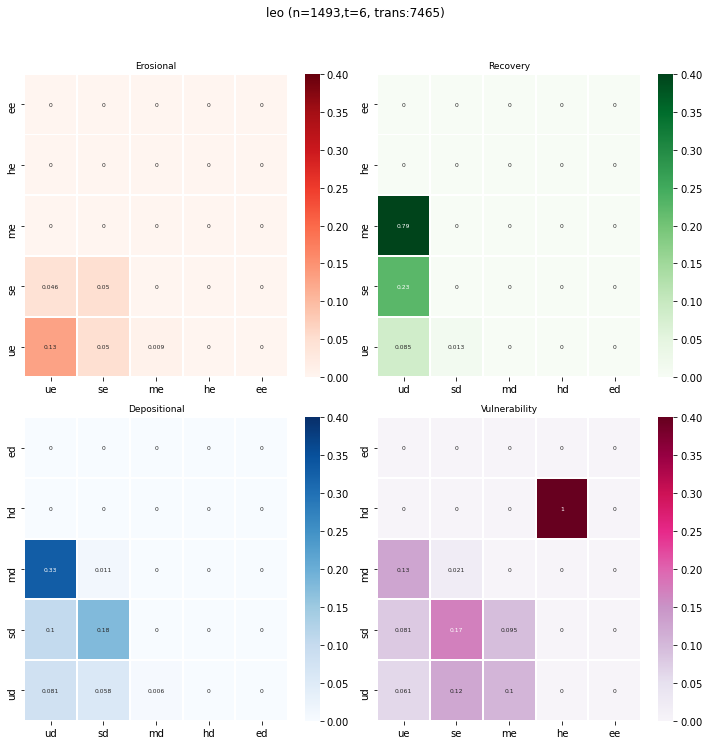

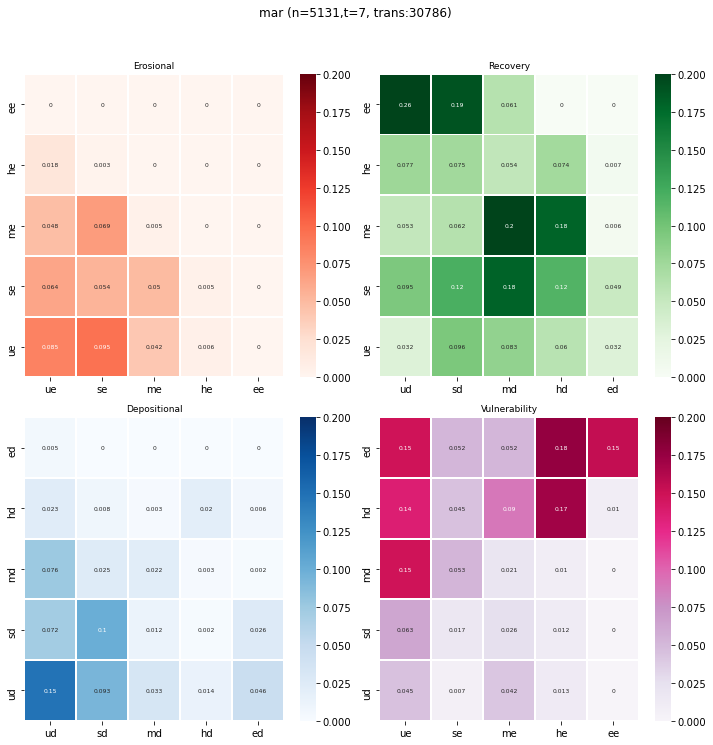

In [17]:
%%time

# For all the locations, compute e-BCD indices and Steady-States at the location level.

e_bcds,ss = BCDs_compute(dataset, weights_dict=weights_dict,
                         mode='all',
                         plot_it=True, unique_field="geometry", label_order=label_order,
                        save_it=False,fig_size=(10, 10),
                         save_output=None)

## Dynamic States Weighted Index

These indexes are weighted based on the severity and trend of each transiction in the context of the sub-matrix.
In the erosion submatrix for example, the transitions from Extreme to Small Erosion states reflects a reduced erosional activity, which positive affects sand budget dynamics. Inversely, from Small to Extreme states will indicate an increased level of erosion and will be weighted with a high and positive weights (+ 25). 

In [19]:
# here I translate the submatrix codes into the names and store them in a column

titles=["Erosional", "Recovery", "Depositional","Vulnerability"]

translation=dict(zip(["ee","ed","dd","de"],titles))
e_bcds["states_labels"]=e_bcds["sub_matrix"].map(translation)

e_bcds.query("location=='mar'")

,location,sub_matrix,coastal_markov_idx,trend,sign,states_labels
0,mar,de,1.495,0.235,+,Vulnerability
1,mar,dd,0.739,0.043,+,Depositional
2,mar,ed,2.167,-0.003,-,Recovery
3,mar,ee,0.544,0.003,+,Erosional


''

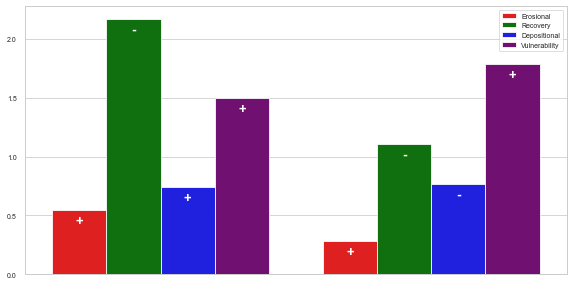

In [22]:
plt.rcParams['font.sans-serif'] = 'Arial'
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = 'sans-serif'

f,ax=plt.subplots(figsize=(8,4))

sb.set_context("paper", font_scale=0.8)
sb.set_style("whitegrid")

loc_order=["mar","leo"]

loc_order=[loc for loc in loc_order if loc in e_bcds.location.unique()]

palette_dyn_states ={"Erosional":"r","Recovery":"g","Depositional":"b","Vulnerability":"purple"}
absolute=False
orders=["Erosional","Recovery","Depositional","Vulnerability"]

if bool(absolute)==True:
    y=abs(e_bcds.coastal_markov_idx)
else:
    y=e_bcds.coastal_markov_idx


plot_bars=sb.barplot(data=e_bcds,x="location", y=y,hue="states_labels", hue_order=orders,
          order=loc_order, palette=palette_dyn_states)


# ax.set_xticklabels(labels=["Port Fairy","Warrnambool","Marengo","Apollo Bay","Pt. Roadk.","St. Leo.","Portarlington","Cowes","Inverloch","Seaspray"])
ax.set_xticklabels
ax.set_xticklabels("")
ax.set_xlabel("")
ax.set_ylabel("")


txt_heights=[i.get_height() for i in ax.patches]

signs=[]
for i in orders:
    for j in loc_order:
        sign=e_bcds.query(f"location == '{j}' & states_labels=='{i}'").sign.values
        signs.append(sign)
        

for p,txt_height,sign in zip(ax.patches,txt_heights,signs):
    width, height = p.get_width(), p.get_height()
    x, y = p.get_xy()
    ax.text(x+width/2,
         txt_height - 0.095, 
         sign[0], 
         horizontalalignment='center', 
         verticalalignment='center',
            color="white",
           fontsize=13,
           fontweight='heavy')
    
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[:], labels=labels[:], loc=0)

plt.tight_layout()

#f.savefig(r'E:\\chapter_4\\chloe_inv\\add\\chloe_full_2yrs_inv_hotspots.png', dpi=1200)
;

# Steady State

In [23]:
ss_victoria_ordered=ss.loc[label_order,loc_order]
ss_victoria_ordered.drop("nnn",inplace=True)
ss_victoria_ordered

,mar,leo
ed,0.018811,NaN
hd,0.041202,0.000118
md,0.056252,0.011315
sd,0.059544,0.042113
ud,0.067480,0.135834
ue,0.061527,0.057433
se,0.050231,0.073220
me,0.047177,0.029800
he,0.023203,0.000118
ee,0.004792,0.000118


<AxesSubplot:>

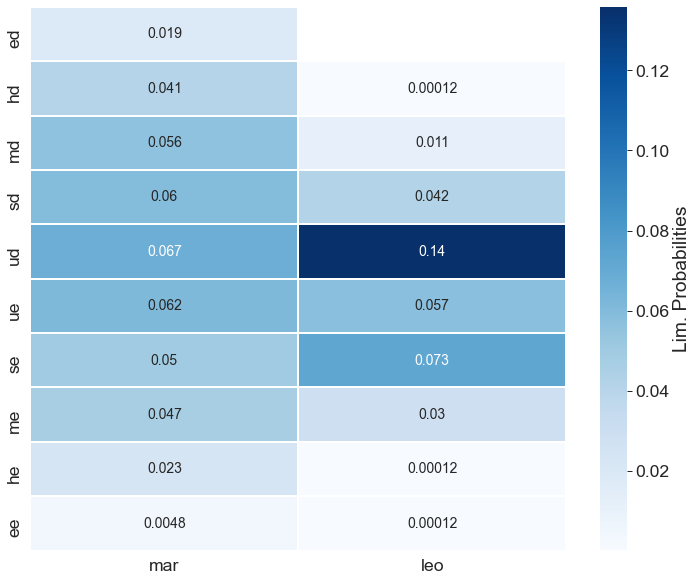

In [25]:
plt.rcParams['font.sans-serif'] = 'Arial'
# Then, "ALWAYS use sans-serif fonts"
plt.rcParams['font.family'] = 'sans-serif'
sb.set_context("paper", font_scale=2)


f,ax=plt.subplots(figsize=(12,10))

sb.heatmap(ss_victoria_ordered, cmap="Blues",annot=True,
           annot_kws={'size':14},linewidths=1,linecolor="white", cbar_kws={'label': 'Lim. Probabilities'})
#f.savefig(r'E:\\chapter_4\\chloe_inv\\add\\chloe_full_2yrs_inv_SS_hotspots.png', dpi=1200)

### Computing the Residual BCD Indices

In this case, no weigths are applied.

The residual is simply the difference between erosional and depositional probabilities in the Steady-State distribution, multiplicated by 100 for readability purposes.

Here below, the dataframe returns the residual column, which is what we plot in __Figure 1a__ of the paper.




In [26]:
# No weight are needed for the r-BCD index. Thus, we set a weigth dictionary of 1 (FUNCTION TO UPDATE).

weights_dict={"ee":1,"ed":1,
        "he":1,"hd":1,
        "me":1,"md":1,
        "se":1,"sd":1,
        "ue":1,"ud":1}

weigths_series=pd.Series(weights_dict,weights_dict.keys(), name="weight" )


# Apply the weights
steady_state_victoria_ordered_w=ss_victoria_ordered.join(weigths_series, how="inner")
weighted_matrix=steady_state_victoria_ordered_w.iloc[:,:-1].multiply(steady_state_victoria_ordered_w.weight, axis="index")

# Create erosion and deposition sub-matrix
erosion=weighted_matrix.iloc[5:,:].transpose()
erosion["erosion"]=erosion.sum(axis=1)

deposition=weighted_matrix.iloc[:-5,:].transpose()
deposition["deposition"]=deposition.sum(axis=1)

# Compute erosion residuals
indexes_vic=(deposition.deposition -erosion.erosion) * 100    # to make the indexes more readable
indexes_vic=pd.DataFrame(pd.Series(indexes_vic, name="residual"))
indexes_vic.reset_index(inplace=True)
indexes_vic.rename({"index":"location"},axis=1, inplace=True)

# Put all into one table
deposition["erosion"]=erosion.erosion
to_plot=deposition.reset_index()[["index","deposition","erosion"]].rename({"index":"location"},axis=1)

to_print_table=to_plot.merge(indexes_vic, on="location", how="left")
to_plot=to_print_table.melt(id_vars=["location"],var_name="process",value_name="coastal_index")


to_print_table

,location,deposition,erosion,residual
0,mar,0.243289,0.186929,5.635999
1,leo,0.189379,0.160689,2.869018


___

# Transect Level Sand Dynamics with BCDs